# Logistic Regression with a Neural network

In [1]:
from io import IncrementalNewlineDecoder
import numpy as np
import copy
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage

%matplotlib inline
%load_ext autoreload
%autoreload 2


In [2]:
from google.colab import files
uploaded = files.upload()  # Opens a file upload dialog


Saving archive (8).zip to archive (8).zip


In [3]:
# Assuming the zip file is already uploaded or in the current directory
!unzip "/content/archive (8).zip" -d extracted_files


Archive:  /content/archive (8).zip
  inflating: extracted_files/catvnoncat/test_catvnoncat.h5  
  inflating: extracted_files/catvnoncat/train_catvnoncat.h5  


In [4]:
import os

# List extracted files
extracted_path = 'extracted_files'
for root, dirs, files in os.walk(extracted_path):
    for file in files:
        print(os.path.join(root, file))


extracted_files/catvnoncat/train_catvnoncat.h5
extracted_files/catvnoncat/test_catvnoncat.h5


In [5]:
import h5py
import numpy as np

def load_dataset():
    # File paths
    train_file_path = 'extracted_files/catvnoncat/train_catvnoncat.h5'
    test_file_path = 'extracted_files/catvnoncat/test_catvnoncat.h5'

    # Load training data
    with h5py.File(train_file_path, 'r') as train_data:
        train_set_x_orig = np.array(train_data['train_set_x'])  # Features (images)
        train_set_y = np.array(train_data['train_set_y'])       # Labels (0 for non-cat, 1 for cat)
        classes = np.array(train_data['list_classes'])          # Class labels (e.g., [0, 1])

    # Load testing data
    with h5py.File(test_file_path, 'r') as test_data:
        test_set_x_orig = np.array(test_data['test_set_x'])  # Features (images)
        test_set_y = np.array(test_data['test_set_y'])       # Labels (0 for non-cat, 1 for cat)

    return train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes

# Load the dataset
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

y = 1, it's a 'cat' picture.


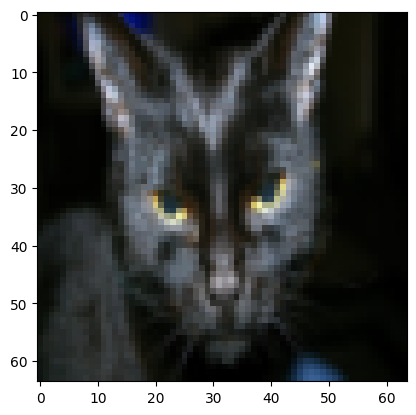

In [42]:
# Visualize an example from the training set
index = 25

# Display the image
plt.imshow(train_set_x_orig[index])

# Fix indexing for train_set_y
if train_set_y.ndim == 2:  # If train_set_y has 2 dimensions (e.g., (1, 209))
    label = train_set_y[0, index]
else:  # If train_set_y has 1 dimension (e.g., (209,))
    label = train_set_y[index]

# Decode the label and print information
print("y = " + str(label) + ", it's a '" + classes[label].decode("utf-8") + "' picture.")


**Exercise 1**
Find the values for:

- m_train (number of training examples)
- m_test (number of test examples)
- num_px (= height = width of a training image)

Remember that train_set_x_orig is a numpy-array of shape (m_train, num_px, num_px, 3). For instance, you can access m_train by writing train_set_x_orig.shape[0].

In [43]:
#(≈ 3 lines of code)
# m_train =
# m_test =
# num_px =
# YOUR CODE STARTS HERE
m_train = train_set_x_orig.shape[0]
m_test =  test_set_x_orig.shape[0]
num_px = train_set_x_orig.shape[1]


# YOUR CODE ENDS HERE

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (209,)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (50,)


**Exercise 2**

Reshape the training and test data sets so that images of size (num_px, num_px, 3) are flattened into single vectors of shape (num_px  ∗
  num_px  ∗
  3, 1).

A trick when you want to flatten a matrix X of shape (a,b,c,d) to a matrix X_flatten of shape (b ∗
 c ∗
 d, a) is to use:

X_flatten = X.reshape(X.shape[0], -1).T      # X.T is the transpose of X

In [44]:
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T

print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

train_set_x_flatten shape: (12288, 209)
train_set_y shape: (209,)
test_set_x_flatten shape: (12288, 50)
test_set_y shape: (50,)


**To represent color images, the red, green and blue channels (RGB) must be specified for each pixel, and so the pixel value is actually a vector of three numbers ranging from 0 to 255.**

Let's standardize our dataset.

In [45]:
train_set_x = train_set_x_flatten / 255.
test_set_x = test_set_x_flatten / 255.

# General Architecture of the Learning Algorithm

**It's time to design a simple algorithm to distinguish cat images from non-cat images.**

You will build a Logistic Regression, using a Neural Network mindset. The following Figure explains why Logistic Regression is actually a very simple Neural Network!



**Mathematical expression of the algorithm:**

For one example
 **𝑥(𝑖):𝑧(𝑖)=𝑤𝑇𝑥(𝑖)+𝑏 **

(1)
**𝑦̂ (𝑖)=𝑎(𝑖)=𝑠𝑖𝑔𝑚𝑜𝑖𝑑(𝑧(𝑖))**


(2)
**(𝑎(𝑖),𝑦(𝑖))=−𝑦(𝑖)log(𝑎(𝑖))−(1−𝑦(𝑖))log(1−𝑎(𝑖))**

(3)

The cost is then computed by summing over all training examples:
𝐽=1𝑚∑𝑖=1𝑚(𝑎(𝑖),𝑦(𝑖))(6)

**4.1 - Helper functions**

**Exercise 3 - sigmoid**
Using your code from "Python Basics", implement sigmoid(). As you've seen in the figure above, you need to compute  

**𝑠𝑖𝑔𝑚𝑜𝑖𝑑(𝑧)=11+𝑒−𝑧
  for  𝑧=𝑤𝑇𝑥+𝑏**
  
  to make predictions. Use np.exp().

In [46]:
def sigmoid(z):
  s = 1/(1+np.exp(-z))

  return s


In [47]:
print("sigmoid([0,2]) = "+ str(sigmoid(np.array([0,2]))))

#sigmoid_test(sigmoid)

sigmoid([0,2]) = [0.5        0.88079708]


In [12]:
x = np.array([0.5,0,2.0])
output = sigmoid(x)
print(output)

[0.62245933 0.5        0.88079708]


**4.2 - Initializing parameters**

**Exercise 4**
 - initialize_with_zeros
Implement parameter initialization in the cell below. You have to initialize w as a vector of zeros. If you don't know what numpy function to use, look up np.zeros() in the Numpy library's documentation.

In [48]:
def initialize_with_zeros(dim):
  w = np.zeros((dim,1))
  b = 0.0

  return w,b


In [49]:
dim = 2
w, b = initialize_with_zeros(dim)
print ("w = " + str(w))
print ("b = " + str(b))

#initialize_with_zeros_test_1(initialize_with_zeros)
#initialize_with_zeros_test_2(initialize_with_zeros)

w = [[0.]
 [0.]]
b = 0.0


**4.3 - Forward and Backward propagation
Now that your parameters are initialized, you can do the "forward" and "backward" propagation steps for learning the parameters.**


**Exercise 5 - propagate
Implement a function propagate() that computes the cost function and its gradient.**

Hints:

Forward Propagation:

You get X
You compute
** 𝐴=𝜎(𝑤𝑇𝑋+𝑏)=(𝑎(1),𝑎(2),...,𝑎(𝑚−1),𝑎(𝑚))**

You calculate the cost function:  **𝐽=−1𝑚∑𝑚𝑖=1(𝑦(𝑖)log(𝑎(𝑖))+(1−𝑦(𝑖))log(1−𝑎(𝑖)))**

Here are the two formulas you will be using:

**∂𝐽∂𝑤=1𝑚𝑋(𝐴−𝑌)𝑇(7)
∂𝐽∂𝑏=1𝑚∑𝑖=1𝑚(𝑎(𝑖)−𝑦(𝑖))**

In [50]:
def propagate(w,b,X,Y):
  m = X.shape[1]

  A= sigmoid(np.dot(w.T,X)+b)
  cost = -1 * np.sum((Y*np.log(A) + (1-Y)*np.log(1-A))/m)


  dw = np.dot(X, (A-Y).T)/m
  db= np.sum(A-Y)/m

  cost = np.squeeze(np.array(cost))

  grads = {"dw":dw,
           "db":db}

  return grads,cost


In [51]:
w = np.array([[1.],[2]])
b = 1.5

X =np.array([[1., -2., -1.],[3., 0.5, -3.2]])
Y = np.array([[1,1,0]])
grads, cost = propagate(w, b, X, Y)

assert type(grads["dw"]) == np.ndarray
assert grads["dw"].shape == (2, 1)
assert type(grads["db"]) == np.float64

print ("w = " + str(grads["dw"]))
print ("b = " + str(grads["db"]))
print ("cost = " + str(cost))

w = [[ 0.25071532]
 [-0.06604096]]
b = -0.12500404500439652
cost = 0.15900537707692405


**4.4 - Optimization**

You have initialized your parameters.
You are also able to compute a cost function and its gradient.
Now, you want to update the parameters using gradient descent.

**Exercise 6 - optimize**

Write down the optimization function. The goal is to learn  𝑤
  and  𝑏
  by minimizing the cost function  𝐽
 . For a parameter  𝜃
 , the update rule is  𝜃=𝜃−𝛼 𝑑𝜃
 , where  𝛼
  is the learning rate.

In [52]:
def optimize(w,b, X,Y, num_iterations =100, learning_rate = 0.009, print_cost=False):

  w = copy.deepcopy(w)
  b = copy.deepcopy(b)

  costs= []

  for i in range(num_iterations):
    grads, cost = propagate(w,b,X,Y)

    # retrive derivatives from grads
    dw = grads["dw"]
    db = grads["db"]

    w = w - learning_rate * dw
    b = b - learning_rate * db

    if i % 100 == 0:
      costs.append(cost)

      # print the cost every 100 training iterations
      if print_cost:
        print("Cost after iteration %i: %f" %(i, cost))

  params={"w":w,
        "b":b}

  grads = {"dw":dw,
         "db":db}

  return params, grads, costs


In [53]:
params, grads, costs = optimize(w, b, X, Y, num_iterations=100, learning_rate=0.009, print_cost=False)

print ("w = " + str(params["w"]))
print ("b = " + str(params["b"]))
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print("Costs = " + str(costs))

#optimize_test(optimize)

w = [[0.80956046]
 [2.0508202 ]]
b = 1.5948713189708588
dw = [[ 0.17860505]
 [-0.04840656]]
db = -0.08888460336847771
Costs = [array(0.15900538)]


**Exercise 7 - predict**
The previous function will output the learned w and b. We are able to use w and b to predict the labels for a dataset X. Implement the predict() function. There are two steps to computing predictions:

Calculate  **𝑌̂ =𝐴=𝜎(𝑤𝑇𝑋+𝑏)**


Convert the entries of a into 0 (if activation <= 0.5) or 1 (if activation > 0.5), stores the predictions in a vector Y_prediction. If you wish, you can use an if/else statement in a for loop (though there is also a way to vectorize this).

In [54]:
def predict(w,b, X):
  m = X.shape[1]
  Y_prediction = np.zeros((1,m))
  w = w.reshape(X.shape[0],1)

  A = sigmoid(np.dot(w.T, X) +b)

  for i in range(A.shape[1]):
    if A[0,i] > 0.5:
      Y_prediction[0,i] = 1;
    else:
      Y_prediction[0,i] = 0

  return Y_prediction


In [55]:
w = np.array([[0.1124579], [0.23106775]])
b = -0.3
X = np.array([[1., -1.1, -3.2],[1.2, 2., 0.1]])
print ("predictions = " + str(predict(w, b, X)))


predictions = [[1. 1. 0.]]


**5 - Merge all functions into a model
You will now see how the overall model is structured by putting together all the building blocks (functions implemented in the previous parts) together, in the right order.**


**Exercise 8 - model
Implement the model function. Use the following notation:**

- Y_prediction_test for your predictions on the test set
- Y_prediction_train for your predictions on the train set
- parameters, grads, costs for the outputs of optimize()

In [56]:


def model(X_train, Y_train, X_test, Y_test, num_iterations=2000, learning_rate=0.5, print_cost=False):

    w,b = initialize_with_zeros(X_train.shape[0])
    parameters, grads, costs = optimize(w,b,X_train, Y_train, num_iterations, learning_rate, print_cost)
    w = parameters["w"]
    b = parameters["b"]
    Y_prediction_test = predict(w,b,X_test)
    Y_prediction_train = predict(w,b,X_train)


    # Print train/test Errors
    if print_cost:
        print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
        print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))


    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test,
         "Y_prediction_train" : Y_prediction_train,
         "w" : w,
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}

    return d

In [57]:
logistic_regression_model = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations=2000, learning_rate=0.005, print_cost=True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.584508
Cost after iteration 200: 0.466949
Cost after iteration 300: 0.376007
Cost after iteration 400: 0.331463
Cost after iteration 500: 0.303273
Cost after iteration 600: 0.279880
Cost after iteration 700: 0.260042
Cost after iteration 800: 0.242941
Cost after iteration 900: 0.228004
Cost after iteration 1000: 0.214820
Cost after iteration 1100: 0.203078
Cost after iteration 1200: 0.192544
Cost after iteration 1300: 0.183033
Cost after iteration 1400: 0.174399
Cost after iteration 1500: 0.166521
Cost after iteration 1600: 0.159305
Cost after iteration 1700: 0.152667
Cost after iteration 1800: 0.146542
Cost after iteration 1900: 0.140872
train accuracy: 99.04306220095694 %
test accuracy: 70.0 %


y = 0, you predicted that it is a "non-cat" picture.


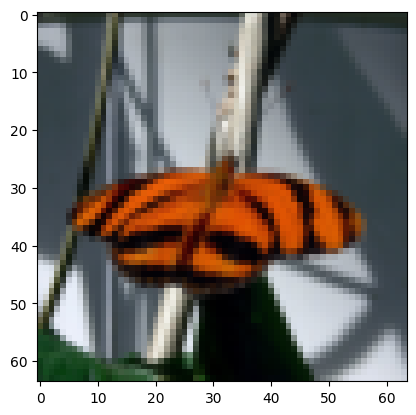

In [70]:
# Example of a wrongly classified picture
index = 45  # Index of the picture

# Reshape test_set_x for visualization
num_px = int(np.sqrt(test_set_x.shape[0] / 3))  # Calculate num_px based on the total number of features and assuming 3 color channels

# Select the image data and reshape it
image_data = test_set_x[:, index]  # Select the image data for the given index
reshaped_image = image_data.reshape((num_px, num_px, 3))  # Reshape the image data

# Display the image
plt.imshow(reshaped_image)

# Access the true label
true_label = test_set_y[0, index] if test_set_y.ndim == 2 else test_set_y[index]

# Access the predicted label
predicted_label = logistic_regression_model['Y_prediction_test'][0, index]

# Print details
print("y = " + str(true_label) +
      ", you predicted that it is a \"" + classes[int(predicted_label)].decode("utf-8") + "\" picture.")

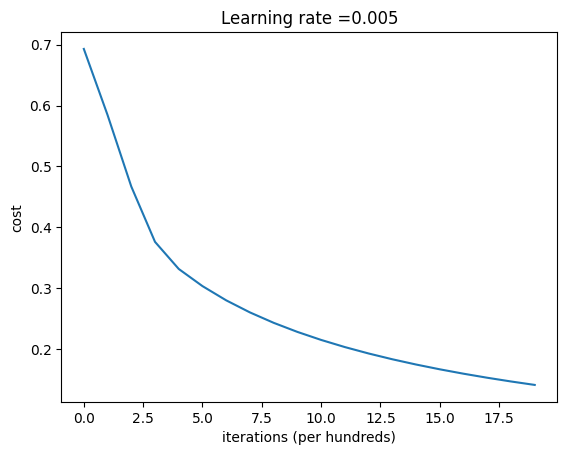

In [38]:
# Plot learning curve (with costs)
costs = np.squeeze(logistic_regression_model['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(logistic_regression_model["learning_rate"]))
plt.show()